In [2]:
from LensCalcPy.survey import *
from LensCalcPy.ffp import *
from LensCalcPy.utils import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d, interp2d
from scipy.integrate import quad, nquad
from tqdm import tqdm
from pathos.multiprocessing import ProcessingPool as Pool
import functools
from scipy.stats import poisson
import seaborn as sns
sns.set_palette("colorblind")

%load_ext autoreload
%autoreload 2

In [2]:
plt.style.use("style.mplstyle")
sns.set_palette("colorblind")

In [3]:
ti = 0.07
tf = 3
from LensCalcPy.parameters import *

In [4]:
def scientific_format(x):
    s = "%.1e" % x
    mantissa, exponent = s.split("e")
    return r"${} \times 10^{{{}}}$".format(mantissa, int(exponent))

def scientific_format_less(x):
    s = "%.1e" % x
    mantissa, exponent = s.split("e")
    return r"$10^{{{}}}$".format(int(exponent))

In [5]:
#Fig 18 of https://arxiv.org/pdf/1701.02151.pdf
mag_arr = [26, 25, 24, 23, 22, 17.5]
efficiency_arr = [0.25, 0.37, 0.62, 0.76, 0.81, 0.81]
# efficiency_dict = {26: 0.25, 25: 0.37, 24: 0.62, 23: 0.76, 22: 0.81}
efficiency_interp = interp1d(mag_arr, efficiency_arr, kind='linear')

#Efficiency Calculation
#Fig 22 panel 2 of https://arxiv.org/pdf/1701.02151.pdf
df = pd.read_csv('mag_distribution_hsc.csv', header=None)
magnitudes = df[0]
weights = df[1]

weighted_avg_efficiency = sum(efficiency_interp(magnitudes) * weights) / sum(weights)
weighted_avg_efficiency

0.7027670115593059

In [6]:
s = Survey(l, b, source_dist = ds, obs_time = obs_time, cadence = cadence, survey_area=survey_area, n_sources=n_sources, efficiency=weighted_avg_efficiency)
s

Survey(l=121.2, b=-21.6, source_dist=770, obs_time=7, cadence = 0.035, survey_area=1.767144375, n_sources=87000000.0, efficiency=0.7027670115593059)

Line of Sight

/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/LensCalcPy/galaxy.py:210: RuntimeWarning: divide by zero encountered in double_scalars
  return rhocM31 / ((r/rsM31) * (1 + r/rsM31)**2)


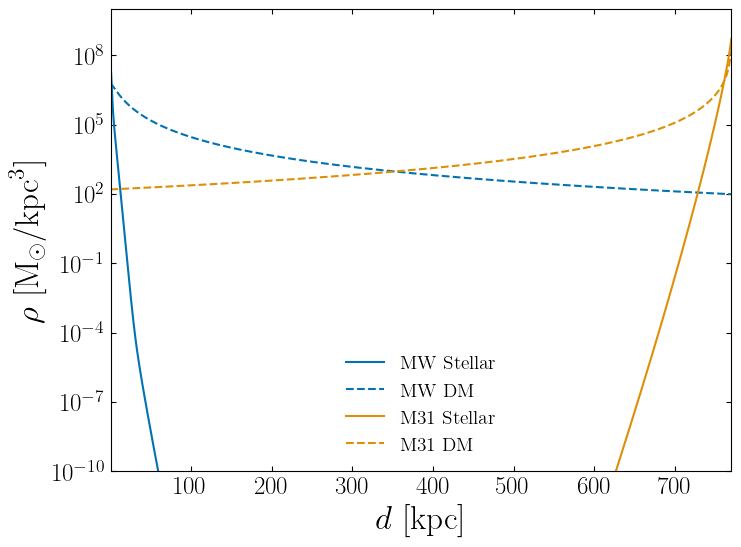

In [7]:
# Calculate the density values for each component using the methods from the classes
d_arr = np.linspace(0, s.source_dist, num=1000)

rho_ffp_mw = [s.mw_model.density_stars(d) for d in d_arr]
rho_ffp_m31 = [s.m31_model.density_stars(d) for d in d_arr]
rho_dm_mw = [s.mw_model.density_dm(d) for d in d_arr]
rho_dm_m31 = [s.m31_model.density_dm(d) for d in d_arr] # Assuming you have a method density_dm in M31Model

plt.plot(d_arr, rho_ffp_mw, label="MW Stellar")
plt.plot(d_arr, rho_dm_mw, label="MW DM", linestyle="--", color="C0")
plt.plot(d_arr, rho_ffp_m31, label="M31 Stellar")
plt.plot(d_arr, rho_dm_m31, label="M31 DM", linestyle="--", color="C1")

plt.xlabel(r"$d$ [kpc]")
plt.ylabel(r"$\rho$ [M$_\odot$/$\mathrm{kpc}^3$]")
# plt.title(r'LoS: l = ${}^\circ$, b = ${}^\circ$'.format(l, b), fontsize=16)

plt.legend()

plt.yscale("log")
plt.xlim(1e0, s.source_dist)
# plt.xlim(1e-2, 1e1)

plt.ylim(1e-10, 1e10)
# plt.tight_layout()
# plt.savefig("figures/line_of_sight.pdf")

plt.show()

In [8]:
# Define Time Array
t_es = np.logspace(-2, 1, 30) #hours
ms = np.logspace(-15, -3, 30) #solar masses

In [9]:
#Power law index
p = 1
s.add_ffp(p)
m_arr = np.logspace(-15, -3, 60)


### Differential Rates

In [57]:
def differential_rate_mw_mass(m, tcad = 0.07, tobs= 3, finite=True, t_fwhm=True):
    return s.ffp.differential_rate_mw_mass_new(m, tcad=tcad, tobs=tobs, finite=finite, epsabs=0, epsrel=1e-1, t_fwhm=t_fwhm)


def differential_rate_m31_mass(m, tcad = 0.07, tobs= 3, finite=True, t_fwhm=True):
    return s.ffp.differential_rate_m31_mass_new(m, tcad=tcad, tobs=tobs, finite=finite, epsabs=0, epsrel=1e-1, t_fwhm=t_fwhm)


In [58]:
with Pool() as pool:
    func = functools.partial(differential_rate_mw_mass, tcad=0.07, tobs=3, finite=True)
    d_gamma_d_ms  = list(tqdm(pool.imap(func, m_arr), total=len(m_arr)))
d_gamma_d_ms = np.array(d_gamma_d_ms)

with Pool() as pool:
    func = functools.partial(differential_rate_mw_mass, tcad=0.07, tobs=3, finite=False)
    d_gamma_d_ms_point  = list(tqdm(pool.imap(func, m_arr), total=len(m_arr)))
d_gamma_d_ms_point = np.array(d_gamma_d_ms_point)

with Pool() as pool:
    func = functools.partial(differential_rate_mw_mass, tcad=1, tobs=3, finite=True)
    d_gamma_d_ms_lowcad  = list(tqdm(pool.imap(func, m_arr), total=len(m_arr)))
d_gamma_d_ms_lowcad = np.array(d_gamma_d_ms_lowcad)

with Pool() as pool:
    func = functools.partial(differential_rate_mw_mass, tcad=1, tobs=3, finite=False)
    d_gamma_d_ms_point_lowcad  = list(tqdm(pool.imap(func, m_arr), total=len(m_arr)))

  0%|          | 0/60 [00:00<?, ?it/s]

100%|██████████| 60/60 [00:14<00:00,  4.17it/s]


/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/LensCalcPy/ffp.py:304: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(second_integral, d_min, d_max, args=(mf), epsabs=epsabs, epsrel=epsrel)
/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/LensCalcPy/ffp.py:304: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(second_integral, d_min, d_max, args=(mf), epsabs=epsabs, epsrel=epsrel)
/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/LensCalcPy/ffp.py:304: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(second_integral, d_min, d_max, args=(mf), epsabs=epsabs, epsrel=epsrel)
/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/LensCalcPy/ffp.py:304: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(second_integral, d_min, d_max, args=(mf), epsabs

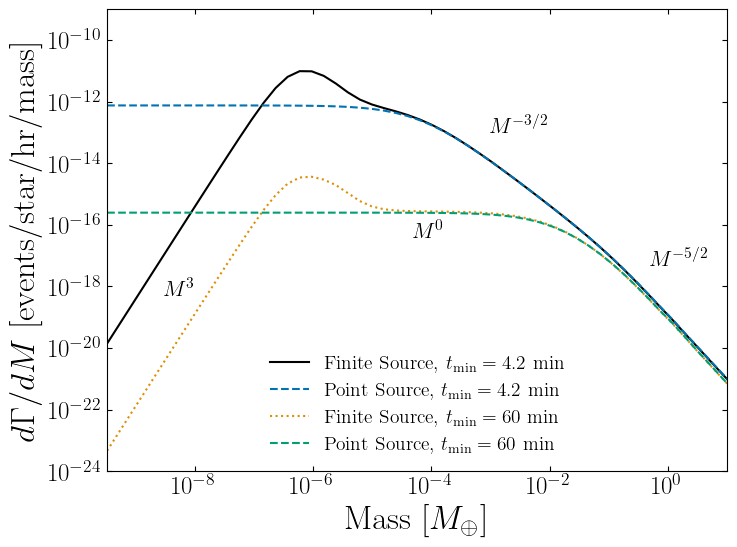

In [61]:
#FWHM Version
plt.loglog(m_arr/3e-6, d_gamma_d_ms, label=r'Finite Source, $t_{\rm{min}} = 4.2 ~\rm{min}$', color='k')
plt.loglog(m_arr/3e-6, d_gamma_d_ms_point, label=r'Point Source, $t_{\rm{min}} = 4.2 ~\rm{min}$', ls='--')
plt.loglog(m_arr/3e-6, d_gamma_d_ms_lowcad, label=r'Finite Source, $t_{\rm{min}} = 60 ~\rm{min}$', ls=':')
plt.loglog(m_arr/3e-6, d_gamma_d_ms_point_lowcad, label=r'Point Source, $t_{\rm{min}} = 60 ~\rm{min}$', ls='--', )

# plt.loglog(m_arr/3e-6, 1.5e-33*m_arr**(-2.5), label="m^{-2.5}")
# plt.loglog(m_arr/3e-6, 1.5e-35*m_arr**(-3))
# plt.loglog(m_arr/3e-6, 1.6e-27*m_arr**(-1.5))

plt.ylim(1e-24, 1e-9)
plt.xlim(np.min(m_arr)/3e-6, 1e1)

plt.text(3e-9, 5e-19, r"$M^3$", fontsize=16)
plt.text(5e-5, 4e-17, r"$M^0$", fontsize=16)
plt.text(1e-3, 1e-13, r"$M^{-3/2}$", fontsize=16)
plt.text(5e-1, 5e-18, r"$M^{-5/2}$", fontsize=16)


plt.xlabel("Mass [$M_{\oplus}$]")
plt.ylabel(r"$d\Gamma/dM$ [events/star/hr/mass]")
# plt.title('MW lens, M31 source')
plt.legend()
# plt.savefig('figures/diff_rate_M_MW_FWHM.pdf')
plt.show()

In [62]:
with Pool() as pool:
    func = functools.partial(differential_rate_m31_mass, tcad=0.07, tobs=3, finite=True)
    d_gamma_d_ms_m31  = list(tqdm(pool.imap(func, m_arr), total=len(m_arr)))
d_gamma_d_ms_m31 = np.array(d_gamma_d_ms_m31)

with Pool() as pool:
    func = functools.partial(differential_rate_m31_mass, tcad=0.07, tobs=3, finite=False)
    d_gamma_d_ms_point_m31  = list(tqdm(pool.imap(func, m_arr), total=len(m_arr)))
d_gamma_d_ms_point_m31 = np.array(d_gamma_d_ms_point_m31)

with Pool() as pool:
    func = functools.partial(differential_rate_m31_mass, tcad=1, tobs=3, finite=True)
    d_gamma_d_ms_lowcad_m31  = list(tqdm(pool.imap(func, m_arr), total=len(m_arr)))
d_gamma_d_ms_lowcad_m31 = np.array(d_gamma_d_ms_lowcad_m31)

with Pool() as pool:
    func = functools.partial(differential_rate_m31_mass, tcad=1, tobs=3, finite=False)
    d_gamma_d_ms_point_lowcad_m31  = list(tqdm(pool.imap(func, m_arr), total=len(m_arr)))
d_gamma_d_ms_point_lowcad_m31 = np.array(d_gamma_d_ms_point_lowcad_m31)

  0%|          | 0/60 [00:00<?, ?it/s]

100%|██████████| 60/60 [00:03<00:00, 18.25it/s]


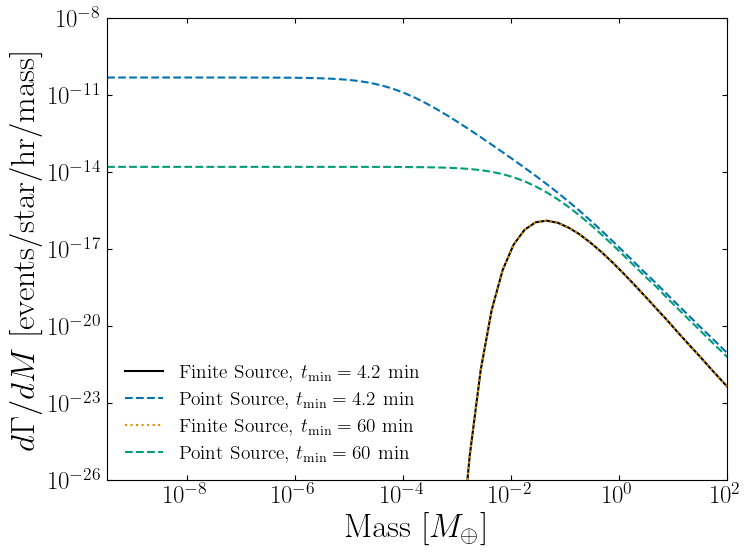

In [65]:
#FWHM Version
#Even in high mass regime, the fwhm is different for point and finite, hence the difference in the rates there
plt.loglog(m_arr/3e-6, d_gamma_d_ms_m31, label=r'Finite Source, $t_{\rm{min}} = 4.2 ~\rm{min}$', color='k')
plt.loglog(m_arr/3e-6, d_gamma_d_ms_point_m31, label=r'Point Source, $t_{\rm{min}} = 4.2 ~\rm{min}$', ls='--')
plt.loglog(m_arr/3e-6, d_gamma_d_ms_lowcad_m31, label=r'Finite Source, $t_{\rm{min}} = 60 ~\rm{min}$', ls=':')
plt.loglog(m_arr/3e-6, d_gamma_d_ms_point_lowcad_m31, label=r'Point Source, $t_{\rm{min}} = 60 ~\rm{min}$', ls='--', )

plt.ylim(1e-26, 1e-8)
plt.xlim(np.min(m_arr)/3e-6, 1e2)

plt.xlabel("Mass [$M_{\oplus}$]")
plt.ylabel(r"$d\Gamma/dM$ [events/star/hr/mass]")
# plt.title('M31 lens, M31 source')
plt.legend()
# plt.savefig('figures/diff_rate_M_M31_FWHM.pdf')

plt.show()

In [66]:
hsc_diff_rate_mw_interp_log = interp1d(np.log10(m_arr), np.log10(d_gamma_d_ms))
def diff_rates_m_mw_interp(m):
    return 10**hsc_diff_rate_mw_interp_log(np.log10(m))

hsc_rates_mw = np.array([quad(diff_rates_m_mw_interp, m_arr[i],m_arr[i+1])[0] for i in range(len(m_arr)-1)])

hsc_diff_rate_m31_interp_log = interp1d(np.log10(m_arr), np.log10(d_gamma_d_ms_m31))
def diff_rates_m_m31_interp(m):
    return 10**hsc_diff_rate_m31_interp_log(np.log10(m))

hsc_rates_m31 = np.array([quad(diff_rates_m_m31_interp, m_arr[i],m_arr[i+1])[0] for i in range(len(m_arr)-1)])


mean_values = (m_arr[:-1] + m_arr[1:]) / 2
rate_mw_interp_log = interp1d(np.log10(mean_values), np.log10(hsc_rates_mw), kind='quadratic')
rate_m31_interp_log = interp1d(np.log10(mean_values), np.log10(hsc_rates_m31), kind='quadratic')

def hsc_rates_mw_interp(m):
    return 10**rate_mw_interp_log(np.log10(m))
def hsc_rates_m31_interp(m):
    return 10**rate_m31_interp_log(np.log10(m))

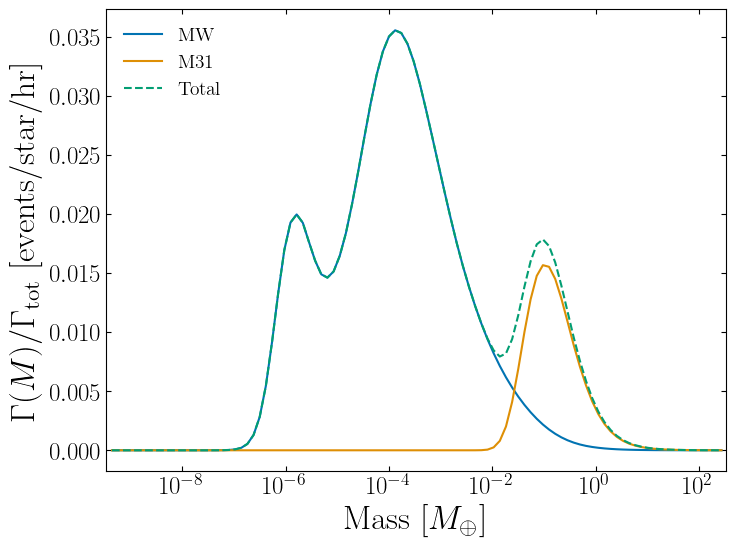

In [68]:
m_arr_dense = np.logspace(np.log10(np.min(mean_values)), np.log10(np.max(mean_values)),100)

# norm_fac = np.sum(hsc_rates_m31+hsc_rates_mw)
norm_fac = np.sum(hsc_rates_mw_interp(m_arr_dense)+hsc_rates_m31_interp(m_arr_dense))
# norm_fac = hsc_rates_mw_interp(m_arr_dense)+hsc_rates_m31_interp(m_arr_dense)


# plt.plot(mean_values/3e-6, hsc_rates_mw/norm_fac, label='MW')
plt.plot(m_arr_dense/3e-6, hsc_rates_mw_interp(m_arr_dense)/norm_fac, label='MW')

# plt.plot(mean_values/3e-6, hsc_rates_m31/norm_fac, label='M31')
plt.plot(m_arr_dense/3e-6, hsc_rates_m31_interp(m_arr_dense)/norm_fac, label='M31')

# plt.plot(mean_values/3e-6,(hsc_rates_m31+hsc_rates_mw)/norm_fac, label='Total', ls='--')
plt.plot(m_arr_dense/3e-6,(hsc_rates_mw_interp(m_arr_dense)+hsc_rates_m31_interp(m_arr_dense))/norm_fac, label='Total', ls='--')


plt.xscale('log')
plt.xlim(min(m_arr)/3e-6, max(m_arr)/3e-6)
plt.xlabel("Mass [$M_{\oplus}$]")
plt.ylabel(r"$\Gamma(M)/\Gamma_{\rm{tot}}$ [events/star/hr]")
# plt.title('MW lens w finite-source effects, M31 source')
plt.legend(loc='upper left')
# plt.savefig('figures/sensitivity_FWHM.pdf')
plt.show()

### Naive FFP Constraints from monochromatic PBH HSC

In [10]:
def get_n_events_pbh(m, finite=True, t_fwhm=True):
    s.add_pbh(m)
    dnds = s.pbh.rate_tot_new(finite=finite, t_fwhm=t_fwhm)
    return s.n_sources*s.efficiency*dnds*s.obs_time

def get_constraint_fdm(m, finite=True, t_fwhm=True):
    n_events = get_n_events_pbh(m, finite=finite, t_fwhm=t_fwhm)
    if n_events != 0:
        return 4.74/n_events
    else:
        return 1

def get_constraint_fdm_parallel(m_pbhs, finite=True, t_fwhm=True):
    with Pool() as p:
        f = functools.partial(get_constraint_fdm, finite=finite, t_fwhm=t_fwhm)
        # results = list(p.imap(f, m_pbhs))
        results = list(tqdm(p.imap(f, m_pbhs), total=len(m_pbhs)))

    return results

In [12]:
m_pbhs = np.logspace(-13, -4, 50) #solar masses

fdm_finite = get_constraint_fdm_parallel(m_pbhs, finite=True)
# fdm_finite = np.array([get_constraint_fdm(m_pbh, finite=True) for m_pbh in tqdm(m_pbhs)])

100%|██████████| 50/50 [00:14<00:00,  3.45it/s]


In [13]:
nstar = 0.14 # per cubic parsec
rho_halo = 0.3 # GeV/cm^3
M_EARTH = 3e-6 # solar masses
M_SUN = 2e30 # kg
cm_to_pc = 3.24e-19
GeV_to_kg = 1.78e-27
GeV_to_solar_mass = GeV_to_kg / M_SUN
rho_halo_Msol_pc3 = rho_halo * GeV_to_solar_mass / cm_to_pc**3
rho_halo_Mearth_pc3 = rho_halo_Msol_pc3 / M_EARTH

f_HM = np.array(fdm_finite) / nstar * rho_halo_Msol_pc3 

ms_earth = m_pbhs/M_EARTH # convert to earth masses
f_HM_earth = f_HM/M_EARTH # convert to earth masses

In [14]:
s.add_ffp(1)

In [15]:
def monochromatic_rate_ffp_new(m, return_sep=True):
    mw_rate = s.ffp.differential_rate_mw_mass_new(m, efficiency=lambda t: s.efficiency, monochromatic=True, epsabs=0, epsrel=1e-1, t_fwhm=True, tcad=0.07, tobs=3)
    m31_rate = s.ffp.differential_rate_m31_mass_new(m, efficiency=lambda t: s.efficiency, monochromatic=True, epsabs=0, epsrel=1e-1, t_fwhm=True, tcad=0.07, tobs=3)
    
    if return_sep:
        return mw_rate, m31_rate
    
    return mw_rate + m31_rate

def expected_nevents_ffp_monochromatic_new(m):
    dnds = monochromatic_rate_ffp_new(m, return_sep=False)
    n_exp = s.n_sources*s.obs_time*dnds
    return n_exp

In [16]:
with Pool() as pool:
    our_N_ffp_perstar = 4.74/np.array(list(tqdm(pool.imap(expected_nevents_ffp_monochromatic_new, m_pbhs), total=len(m_pbhs))))

# our_N_ffp_perstar = 4.74/np.array([expected_nevents_ffp_monochromatic(m) for m in tqdm(m_pbhs)])
# our_N_ffp_perstar = 4.74/np.array([expected_nevents_ffp_monochromatic_new(m) for m in tqdm(m_pbhs)])

our_Mffp_perstar_earth = our_N_ffp_perstar *m_pbhs/M_EARTH # Mass of FFPs per star in earth masses

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [01:28<00:00,  1.77s/it]


/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/LensCalcPy/ffp.py:304: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(second_integral, d_min, d_max, args=(mf), epsabs=epsabs, epsrel=epsrel)
/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/LensCalcPy/ffp.py:304: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(second_integral, d_min, d_max, args=(mf), epsabs=epsabs, epsrel=epsrel)
/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/LensCalcPy/ffp.py:304: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(second_integral, d_min, d_max, args=(mf), epsabs=epsabs, epsrel=epsrel)
/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/LensCalcPy/ffp.py:304: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(second_integral, d_min, d_max, args=(mf), epsabs

In [17]:
#Fig 5 of https://browse.arxiv.org/pdf/1103.0556.pdf at 0.4 M_sol in earth masses
planetary_disk_arr = np.array([0.4374526458281063, 4.292736506804623, 42.930783792067864])*318

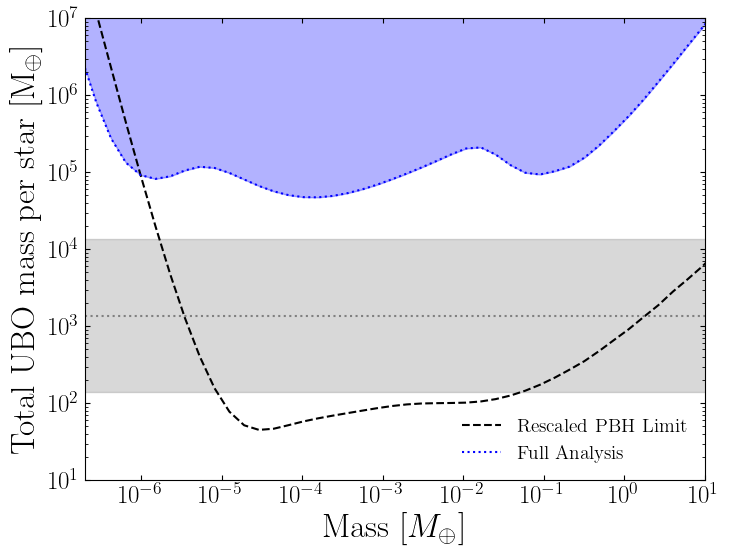

In [20]:
plt.loglog(ms_earth, f_HM_earth, 'k', ls='--', label='Rescaled PBH Limit')
plt.loglog(ms_earth, our_Mffp_perstar_earth, 'blue', ls=':', label='Full Analysis')

plt.fill_between(ms_earth, our_Mffp_perstar_earth, 1e10, alpha=0.3, color='blue')

plt.axhline(planetary_disk_arr[1], color='gray', ls=':')
plt.fill_between(ms_earth, planetary_disk_arr[0], planetary_disk_arr[2], alpha=0.3, color='gray')

plt.xlim(2e-7, 1e1)
plt.ylim(1e1, 1e7)

plt.xlabel(r'Mass [$M_{\oplus}$]')
plt.ylabel('Total UBO mass per star [M$_{\oplus}$]')

plt.tick_params(axis='x', which='both', top=True, direction='in')
plt.tick_params(axis='y', which='both', right=True, direction='in')

# Set the tick spacing on the x-axis to be twice as dense
ax = plt.gca()
ax.xaxis.set_major_locator(plt.LogLocator(base=10.0, numticks=10))

plt.legend(loc='lower right')

# plt.savefig('figures/monochromatic_mass_FWHM.pdf')

plt.show()

### Number of events

In [21]:
def get_n_events(p=1, finite=True):
    s.add_ffp(p)
    diff_rates_mw = np.array([s.ffp.differential_rate_mw_mass_new(m, efficiency=lambda x: weighted_avg_efficiency, t_fwhm=True, finite=finite) for m in ms])
    diff_rates_m31 = np.array([s.ffp.differential_rate_m31_mass_new(m, efficiency=lambda x: weighted_avg_efficiency, t_fwhm=True, finite=finite) for m in ms])
    diff_rates_interp_log = interp1d(np.log10(ms), np.log10(diff_rates_mw + diff_rates_m31))
    def diff_rates_interp(m):
        return 10**diff_rates_interp_log(np.log10(m))
    dnds = quad(diff_rates_interp, min(ms), max(ms), epsabs=0, epsrel=1e-1)[0]
    return s.n_sources*dnds*s.obs_time

def get_n_events_t(p = 1, finite=True):
    s.add_ffp(p)
    diff_rates = s.get_crossing_times_rates_ffp(t_es, finite=finite)
    rate_interp = interp1d(t_es, diff_rates)
    dnds = quad(rate_interp, ti, tf)[0]
    return s.n_sources*s.efficiency*dnds*s.obs_time

## Plots

In [22]:
#Define range of parameters to consider
num_points = 20
p_min = 0.5
p_max = 1.5
p_values = np.linspace(p_min, p_max, num_points) 

In [23]:
n_events_dict = {}

In [24]:
M_sun = 1.99e30
M_earth = 5.97e24
M_EARTH = M_earth/M_sun # Earth mass in solar masses

def get_constraint_dex(m_iso, p=1, finite=True):
    if m_iso < 10**(-14.5):
        raise ValueError('Mass must be greater than 10**(-14.5)')
    
    #Number of total events assuming 1 total per star
    #Note Z doesn't matter for this part of the calculation
    s.add_ffp(p)

    if p in n_events_dict:
        n_events = n_events_dict[p]
    else:
        n_events = get_n_events(p=p, finite=finite)
        n_events_dict[p] = n_events

    #New normalization for Z such that \Gamma * t_obs = 4.74
    Z = 4.74/n_events

    # Normalization check
    if abs(1 - nquad(s.ffp.f_m,[[s.ffp.m_min, s.ffp.m_max]], opts={'points': [s.ffp.m_min, s.ffp.m_min*1e3, s.ffp.m_min*1e6, s.ffp.m_max]})[0]) > 1e-2:
        raise ValueError('Normalization of mass function is off by more than 1e-2')

    #Porportion of ISOs within threshold
    N_ffp_dex = Z * nquad(s.ffp.f_m,[[m_iso*10**(-0.5),m_iso*10**(0.5)]], opts={'points': [s.ffp.m_min, s.ffp.m_min*1e3, s.ffp.m_min*1e6, s.ffp.m_max], 'epsabs':0, 'epsrel':1e-1})[0]

    #Maximum number of allowed ISOs per star of mass m_iso or above
    return N_ffp_dex

In [25]:
get_constraint_dex(1e-5)


4337.298247869237

In [9]:
confidence_level_threshold = 0.05

Nexp = 1
n_events = 0

# Calculate the cumulative probability until it exceeds the threshold
while True:
    cumulative_prob = 0
    for i in range(n_events+1):
        cumulative_prob += poisson.pmf(i, Nexp)

    # cumulative_prob = poisson.pmf(1, Nexp) 
    if cumulative_prob <= confidence_level_threshold:
        break
    Nexp += 0.01 

print(f"The 95% C.L. is reached when Nexp <= {Nexp}")

The 95% C.L. is reached when Nexp <= 2.9999999999999796


### Constraints on local ISO Density

In [27]:
#https://arxiv.org/pdf/1910.08608.pdf handwavy constraint in au^-3

kpc2au = 2.06e8
m_pbh = 1e-10
fpbh = get_constraint_fdm(m_pbh, finite=True)
local_dm_density = density_mw(dist_mw(0))

print("upper limit on number density of ISOs in au^-3 from HSC PBH constrint")
print(local_dm_density*kpc2au**(-3)*fpbh/m_pbh)

upper limit on number density of ISOs in au^-3 from HSC PBH constrint
1.7481907401146802e-11


### Power law plots

In [28]:
#Pg 10 of https://arxiv.org/pdf/1910.08608.pdf
dohanyi_alpha = 2.5
dohanyi_p = dohanyi_alpha/3 
dohanyi_n = 7.2e-11

MOA_Z = 2.18
MOA_p = 0.96
KMT_Z = 0.4
KMT_p = 0.92

N_MOA = quad(lambda x: MOA_Z*(10**x/8)**(-MOA_p), np.log10(0.33), np.log10(6660))[0]
N_KMT = quad(lambda x: KMT_Z*(10**x/38)**(-KMT_p), np.log10(0.33), np.log10(6660))[0]

print(N_MOA)
print(N_KMT)

21.04411106964539
14.872261024601801


In [29]:
def get_power_law(p, finite=True):
    n_events = get_n_events(p=p, finite=finite)
    s.add_ffp(p)

    #New normalization for Z such that \Gamma * t_obs = 4.74
    Z = 4.74/n_events * s.ffp.Z

    m_norm = s.ffp.M_norm

    return Z, m_norm

def dN_dlogM(Z, M, M_norm, p):
    return Z * (M/M_norm)**-p

In [30]:
z_133, m_norm_133 = get_power_law(p=1.33)

In [31]:
z_066, m_norm_066 = get_power_law(p=0.66)

In [32]:
M_arr1 = np.logspace(-6, -3, 100)
M_arr2 = np.logspace(-24, -20, 100)
M_arr3 = np.logspace(-24, -3, 100)

dN_dlogM_arr_MOA = np.array([dN_dlogM(2.18, M, 3e-6*8, 0.96-0.27) for M in M_arr1])
dN_dlogM_arr_MOA2 = np.array([dN_dlogM(2.18, M, 3e-6*8, 0.96+0.47) for M in M_arr1])

dN_dlogM_arr_KMT = np.array([dN_dlogM(0.4, M, 3e-6*38, 0.9) for M in M_arr1])
dN_dlogM_arr_KMT2 = np.array([dN_dlogM(0.4, M, 3e-6*38, 1.2) for M in M_arr1])

dN_dlogM_arr_Do = np.array([dN_dlogM(3.3e16, M, 3e-17 * 3e-6, 0.66) for M in M_arr2])
dN_dlogM_arr_Do2 = np.array([dN_dlogM(3.3e16, M, 3e-17 * 3e-6, 1.33) for M in M_arr2])

dN_dlogM_arr_Do = np.array([dN_dlogM(3.3e16, M, 3e-17 * 3e-6, 0.92-0.06) for M in M_arr2])
dN_dlogM_arr_Do2 = np.array([dN_dlogM(3.3e16, M, 3e-17 * 3e-6, 0.92+0.06) for M in M_arr2])

dN_dlogM_arr_fit = np.array([dN_dlogM(0.4, M, 3e-6*38, 0.92) for M in M_arr3])
dN_dlogM_arr_fiducial = np.array([dN_dlogM(10, M, M_EARTH, 1) for M in M_arr3])

dN_dlogM_arr_ours = np.array([dN_dlogM(z_133, M, m_norm_133, 1.33) for M in M_arr3])
dN_dlogM_arr_ours2 = np.array([dN_dlogM(z_066, M, m_norm_066, 0.66) for M in M_arr3])

do_idx = np.where(abs(dN_dlogM_arr_Do-dN_dlogM_arr_Do2) == min(abs(dN_dlogM_arr_Do-dN_dlogM_arr_Do2)))[0][0]
kmt_idx = np.where(abs(dN_dlogM_arr_KMT-dN_dlogM_arr_KMT2) == min(abs(dN_dlogM_arr_KMT-dN_dlogM_arr_KMT2)))[0][0]
moa_idx = np.where(abs(dN_dlogM_arr_MOA-dN_dlogM_arr_MOA2) == min(abs(dN_dlogM_arr_MOA-dN_dlogM_arr_MOA2)))[0][0]

In [33]:
m_values = np.logspace(-14, -4, 16) #in solar masses
local_stellar_density = 0.1 * 1e9 # number of stars per cubic kpc
# local_stellar_density = 0.04 * 1e9 # solar mass per cubic kpc

p_values_mass = np.array([0.66, 1, 1.33])

def get_num_density(Z, M, M_norm, p):
    '''
    Returns the number density of objects within 1 dex of M in au^-3
    '''
    M_arr = np.linspace(np.log10(M)-0.6, np.log10(M)+0.6, 100)
    dN_dlogM_arr = np.array([dN_dlogM(Z, 10**m, M_norm, p) for m in M_arr])
    interp = interp1d(M_arr, dN_dlogM_arr)
    return quad(interp, np.log10(M)-0.5, np.log10(M)+0.5)[0] * local_stellar_density * kpc2au ** (-3)

In [34]:
num_densities_MOA = np.array([get_num_density(2.18, M, 3e-6*8, 0.96) for M in m_values])
num_densities_KMT = np.array([get_num_density(0.4, M, 3e-6*38, 0.92) for M in m_values])
num_densities_Do = np.array([get_num_density(3.3e16, M, 3e-17 * 3e-6, 0.83) for M in m_values])
num_densities_Fiducial = np.array([get_num_density(10, M, 3e-6, 1) for M in m_values])

/var/folders/qd/09mj47cx551c65glw6y47d6r0000gn/T/ipykernel_16077/4231648228.py:14: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return quad(interp, np.log10(M)-0.5, np.log10(M)+0.5)[0] * local_stellar_density * kpc2au ** (-3)


In [35]:
n_objects_dict_mass = {}
for p_val in p_values_mass:
    n_objects_dict_mass[p_val] = [get_constraint_dex(m, p=p_val) for m in m_values]

In [37]:
#Constraint on 1e-4 * Earth mass objects for p = 1
# get_constraint_dex(m_iso = 1e-4*M_EARTH, p=1)*local_stellar_density * kpc2au ** (-3)
get_constraint_dex(m_iso = 1e-4*M_EARTH, p=1)*local_stellar_density * (1e-9) # in pc^-3


14457660.826230787

In [93]:
#Constraint on 1e-2 * Earth mass objects for p = 1
# get_constraint_dex(m_iso = 1e-2*M_EARTH, p=1)*local_stellar_density * kpc2au ** (-3)

1.4111867270138727e-11

In [94]:
1.3*10**(-11)*kpc2au **3 * (1e-9) #in pc^-3

113643.60800000001

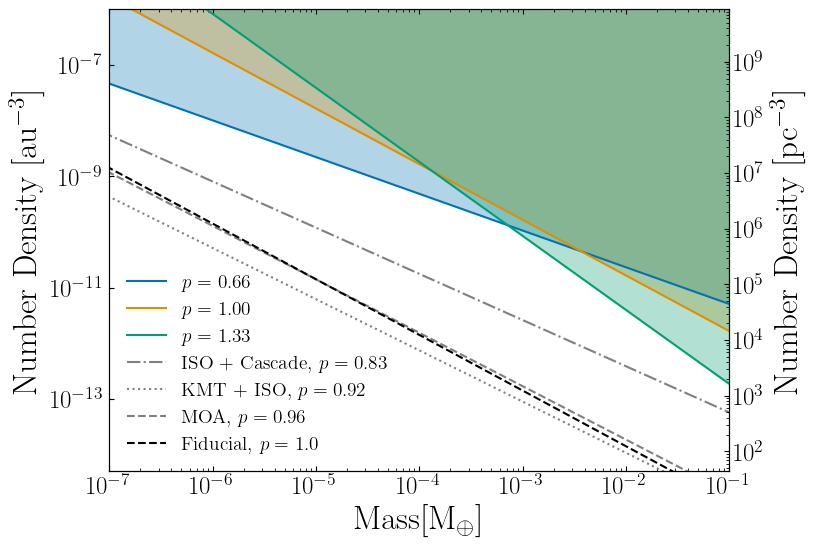

In [39]:
au3_to_pc3 = 1.0 / (206265.0 ** 3)

plt.figure()

# Loop over the dictionary items
for p, n_objects_arr in n_objects_dict_mass.items():
    num_densities = np.array(n_objects_arr) * local_stellar_density * kpc2au ** (-3)

    plt.plot(m_values/M_EARTH, num_densities, label=f'$p = $ {p:.2f}')
    plt.fill_between(m_values/M_EARTH, num_densities, 1, alpha=0.3)

plt.plot(m_values/M_EARTH, num_densities_Do, label='ISO + Cascade, $p = 0.83$', color='gray', linestyle='-.')
plt.plot(m_values/M_EARTH, num_densities_KMT, label='KMT + ISO, $p = 0.92$', color='gray', linestyle=':')
plt.plot(m_values/M_EARTH, num_densities_MOA, label='MOA, $p = 0.96$', color='gray', linestyle='--')
plt.plot(m_values/M_EARTH, num_densities_Fiducial, label='Fiducial, $p = 1.0$', color='black', linestyle='--')


plt.yscale('log')
plt.xscale('log')

plt.ylabel(r'Number Density [au$^{-3}$]')
plt.xlabel(r'$\rm{Mass} [ M_\oplus ]$')
# plt.title(r'Max Number Density of UBOs within 1 Dex')

# plt.xlim([min(m_values)/M_EARTH, max(m_values)/M_EARTH])
plt.xlim([1e-7, 1e-1])


#min and max number density in au^-3
ymin = 5e-15
ymax = 1e-6
plt.ylim([ymin, ymax])

plt.legend(loc='lower left', frameon=False)

plt.tick_params(axis='both', direction='in', which='both', bottom=True, top=True, left=True, right=True)

# creating a twin axis
ax2 = plt.twinx()
ax2.set_ylabel(r'Number Density [pc$^{-3}$]')

# set the same y-scale as the left side
ax2.set_yscale('log')

# convert y limit from au^-3 to pc^-3 using conversion_factor
plt.ylim([ymin/au3_to_pc3, ymax/au3_to_pc3])

# ticks on right side
ax2.tick_params(axis='y', direction='in', which='both')

# plt.savefig('figures/number_density_iso_mass_FWHM.pdf')

plt.show()

### Predicted Number of Events

### Velocity Dependence

In [10]:
p = 1.0
# p = 2.0
f = Ffp(p, l=l, b=b)
ts = np.logspace(-2, 1, num=40)
ti = 0.07
tf = 3

In [11]:
def compute_diff_rate_mw(t):
    return f.differential_rate_mw(t, finite=True, t_fwhm=True)

def compute_diff_rate_m31(t):
    return f.differential_rate_m31(t, finite=True, t_fwhm=True)

def compute_diff_rate_mw_60(t):
    return f.differential_rate_mw(t, finite=True, v_disp=60, t_fwhm=True)

def compute_diff_rate_m31_120(t):
    return f.differential_rate_m31(t, finite=True, v_disp=120, t_fwhm=True)

def compute_diff_rate_mw_15(t):
    return f.differential_rate_mw(t, finite=True, v_disp=15, t_fwhm=True)

def compute_diff_rate_m31_30(t):
    return f.differential_rate_m31(t, finite=True, v_disp=30, t_fwhm=True)

In [12]:
with Pool() as pool:
    diff_rates_finite_mw = list(tqdm(pool.imap(compute_diff_rate_mw, ts), total=len(ts)))
    diff_rates_finite_m31 = list(tqdm(pool.imap(compute_diff_rate_m31, ts), total=len(ts)))
    diff_rates_finite_mw_60 = list(tqdm(pool.imap(compute_diff_rate_mw_60, ts), total=len(ts)))
    diff_rates_finite_m31_120 = list(tqdm(pool.imap(compute_diff_rate_m31_120, ts), total=len(ts)))
    diff_rates_finite_mw_15 = list(tqdm(pool.imap(compute_diff_rate_mw_15, ts), total=len(ts)))
    diff_rates_finite_m31_30 = list(tqdm(pool.imap(compute_diff_rate_m31_30, ts), total=len(ts)))


  0%|          | 0/40 [00:00<?, ?it/s]/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/LensCalcPy/ffp.py:164: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  result, error = quad(integrand_logm, logm_min, logm_max, epsabs=epsabs, epsrel=epsrel)
  2%|▎         | 1/40 [09:49<6:23:19, 589.74s/it]/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/LensCalcPy/ffp.py:164: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the diffic

In [16]:
diff_rates_finite_mw = np.array(diff_rates_finite_mw)
diff_rates_finite_m31 = np.array(diff_rates_finite_m31)
diff_rates_finite_mw_60 = np.array(diff_rates_finite_mw_60)
diff_rates_finite_m31_120 = np.array(diff_rates_finite_m31_120)
diff_rates_finite_mw_15 = np.array(diff_rates_finite_mw_15)
diff_rates_finite_m31_30 = np.array(diff_rates_finite_m31_30)



In [ ]:
diff_rates_finite_mw = []
for t in tqdm(ts, desc='Computing differential rates for MW (finite=True)'):
    diff_rates_finite_mw.append(f.differential_rate_mw(t, finite=True, t_fwhm=False))
diff_rates_finite_mw = np.array(diff_rates_finite_mw)

diff_rates_finite_m31 = []
for t in tqdm(ts, desc='Computing differential rates for M31 (finite=True)'):
    diff_rates_finite_m31.append(f.differential_rate_m31(t, finite=True, t_fwhm=False))
diff_rates_finite_m31 = np.array(diff_rates_finite_m31)

In [ ]:
diff_rates_finite_mw_60 = []
for t in tqdm(ts, desc='Computing differential rates for MW (finite=True)'):
    diff_rates_finite_mw_60.append(f.differential_rate_mw(t, finite=True, v_disp=60, t_fwhm=False))
diff_rates_finite_mw_60 = np.array(diff_rates_finite_mw_60)

diff_rates_finite_m31_120 = []
for t in tqdm(ts, desc='Computing differential rates for M31 (finite=True)'):
    diff_rates_finite_m31_120.append(f.differential_rate_m31(t, finite=True, v_disp=120, t_fwhm=False))
diff_rates_finite_m31_120 = np.array(diff_rates_finite_m31_120)

Computing differential rates for MW (finite=True): 100%|██████████| 40/40 [04:32<00:00,  6.81s/it]
Computing differential rates for M31 (finite=True): 100%|██████████| 40/40 [02:58<00:00,  4.45s/it]


In [ ]:
diff_rates_finite_mw_15 = []
for t in tqdm(ts, desc='Computing differential rates for MW (finite=True)'):
    diff_rates_finite_mw_15.append(f.differential_rate_mw(t, finite=True, v_disp=15, t_fwhm=False))
diff_rates_finite_mw_15 = np.array(diff_rates_finite_mw_15)

diff_rates_finite_m31_30 = []
for t in tqdm(ts, desc='Computing differential rates for M31 (finite=True)'):
    diff_rates_finite_m31_30.append(f.differential_rate_m31(t, finite=True, v_disp=30, t_fwhm=False))
diff_rates_finite_m31_30 = np.array(diff_rates_finite_m31_30)

Computing differential rates for MW (finite=True): 100%|██████████| 40/40 [04:28<00:00,  6.72s/it]
Computing differential rates for M31 (finite=True): 100%|██████████| 40/40 [02:50<00:00,  4.26s/it]


In [13]:
M_norm = 3e-6
Z_fiducial = 10
z_earth =  Z_fiducial/(f.Z*(M_norm/f.M_norm)**(-p))

In [14]:
scientific_format(z_earth)

'$1.3 \\times 10^{10}$'

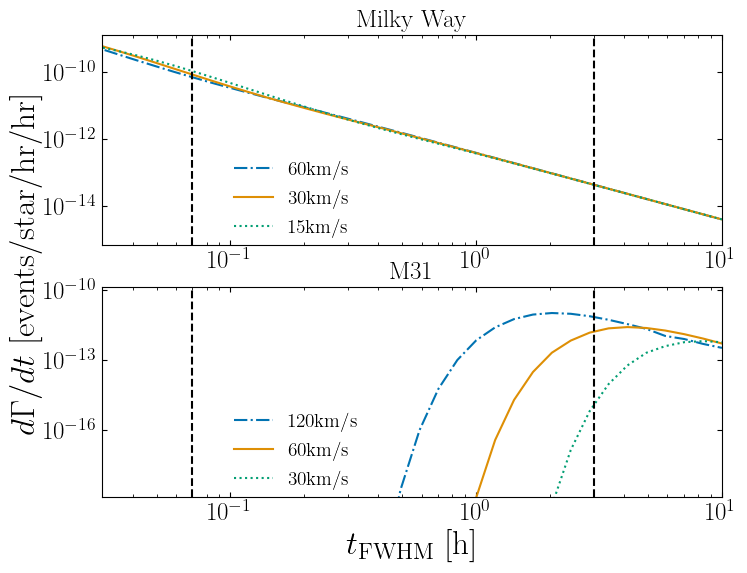

In [34]:
# TFWHM
fig, axs = plt.subplots(2)
ti = 0.07
tf = 3

# First subplot
axs[0].loglog(ts, diff_rates_finite_mw_60*z_earth, label="60km/s", linestyle='-.')
axs[0].loglog(ts, diff_rates_finite_mw*z_earth, label="30km/s", linestyle='-')
axs[0].loglog(ts, diff_rates_finite_mw_15*z_earth, label="15km/s", linestyle=':')

axs[0].axvline(ti, color='black', linestyle='--')
axs[0].axvline(tf, color='black', linestyle='--')

axs[0].set_title('Milky Way')
# axs[0].set_xlim(min(ts)*1.8, max(ts))
axs[0].set_xlim(min(ts)*3, max(ts))

# axs[0].set_ylim(1e-24,5e-19)
axs[0].set_ylim(5e-26*z_earth,1e-19*z_earth)

axs[0].legend(loc=(2e-1, 1e-13))

# Second subplot
axs[1].loglog(ts, diff_rates_finite_m31_120*z_earth, label="120km/s ", linestyle='-.')
axs[1].loglog(ts, diff_rates_finite_m31*z_earth, label="60km/s ", linestyle='-')
axs[1].loglog(ts, diff_rates_finite_m31_30*z_earth, label="30km/s ", linestyle=':')

axs[1].axvline(ti, color='black', linestyle='--')
axs[1].axvline(tf, color='black', linestyle='--')

axs[1].set_xlabel(r"$t_{\rm{FWHM}}$ [h]")
# axs[1].set_xlabel(r"$t_{\rm{FWHM}}$ [h]")
axs[1].set_title('M31')
axs[1].set_xlim(min(ts)*3, max(ts))

axs[1].set_ylim(1e-29*z_earth,1e-20*z_earth)
axs[1].legend(loc=(2e-1, 1e-16))

fig.text(0.01, 0.5, r"$d\Gamma/dt$ [events/star/hr/hr]", va='center', rotation='vertical', fontsize=24)   

# plt.savefig('figures/differential_rate_velocity_FWHM.pdf')
# Show plot
# plt.tight_layout()
plt.show()


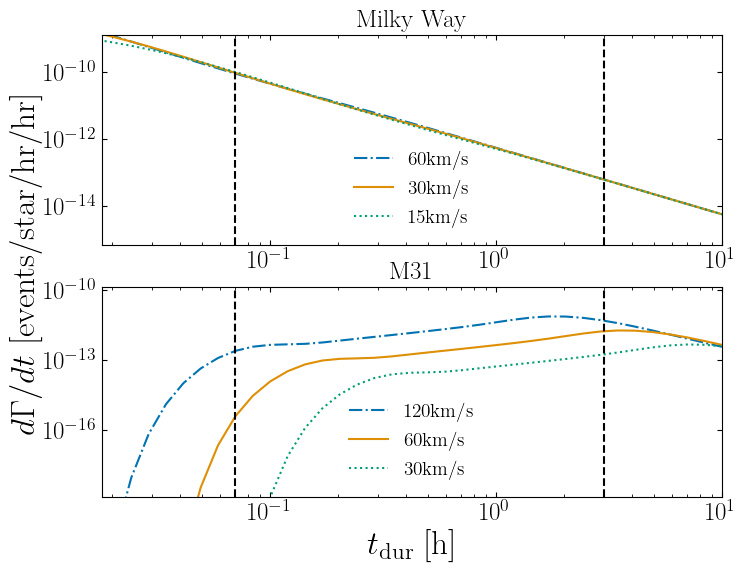

In [92]:
# Create a figure and a grid of subplots
fig, axs = plt.subplots(2)
ti = 0.07
tf = 3

# First subplot
axs[0].loglog(ts, diff_rates_finite_mw_60*z_earth, label="60km/s", linestyle='-.')
axs[0].loglog(ts, diff_rates_finite_mw*z_earth, label="30km/s", linestyle='-')
axs[0].loglog(ts, diff_rates_finite_mw_15*z_earth, label="15km/s", linestyle=':')

axs[0].axvline(ti, color='black', linestyle='--')
axs[0].axvline(tf, color='black', linestyle='--')

axs[0].set_title('Milky Way')
axs[0].set_xlim(min(ts)*1.8, max(ts))

# axs[0].set_ylim(1e-24,5e-19)
axs[0].set_ylim(5e-26*z_earth,1e-19*z_earth)

axs[0].legend(loc='lower center')

# Second subplot
axs[1].loglog(ts, diff_rates_finite_m31_120*z_earth, label="120km/s ", linestyle='-.')
axs[1].loglog(ts, diff_rates_finite_m31*z_earth, label="60km/s ", linestyle='-')
axs[1].loglog(ts, diff_rates_finite_m31_30*z_earth, label="30km/s ", linestyle=':')

axs[1].axvline(ti, color='black', linestyle='--')
axs[1].axvline(tf, color='black', linestyle='--')

axs[1].set_xlabel(r"$t_{\rm{dur}}$ [h]")
# axs[1].set_xlabel(r"$t_{\rm{FWHM}}$ [h]")
axs[1].set_title('M31')
axs[1].set_xlim(min(ts)*1.8, max(ts))
axs[1].set_ylim(1e-29*z_earth,1e-20*z_earth)
axs[1].legend(loc='lower center')

fig.text(0.01, 0.5, r"$d\Gamma/dt$ [events/star/hr/hr]", va='center', rotation='vertical', fontsize=24)   

# plt.savefig('figures/differential_rate_velocity_new.pdf')
# Show plot
# plt.tight_layout()
plt.show()


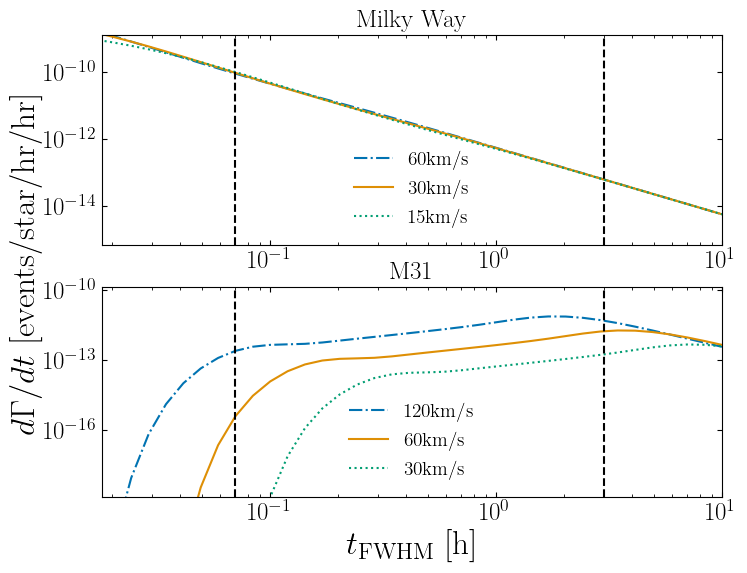

In [13]:
# Create a figure and a grid of subplots
fig, axs = plt.subplots(2)
ti = 0.07
tf = 3

# First subplot
axs[0].loglog(ts, diff_rates_finite_mw_60*z_earth, label="60km/s", linestyle='-.')
axs[0].loglog(ts, diff_rates_finite_mw*z_earth, label="30km/s", linestyle='-')
axs[0].loglog(ts, diff_rates_finite_mw_15*z_earth, label="15km/s", linestyle=':')

axs[0].axvline(ti, color='black', linestyle='--')
axs[0].axvline(tf, color='black', linestyle='--')

axs[0].set_title('Milky Way')
axs[0].set_xlim(min(ts)*1.8, max(ts))

# axs[0].set_ylim(1e-24,5e-19)
axs[0].set_ylim(5e-26*z_earth,1e-19*z_earth)

axs[0].legend(loc='lower center')

# Second subplot
axs[1].loglog(ts, diff_rates_finite_m31_120*z_earth, label="120km/s ", linestyle='-.')
axs[1].loglog(ts, diff_rates_finite_m31*z_earth, label="60km/s ", linestyle='-')
axs[1].loglog(ts, diff_rates_finite_m31_30*z_earth, label="30km/s ", linestyle=':')

axs[1].axvline(ti, color='black', linestyle='--')
axs[1].axvline(tf, color='black', linestyle='--')

axs[1].set_xlabel(r"$t_{\rm{FWHM}}$ [h]")
axs[1].set_title('M31')
axs[1].set_xlim(min(ts)*1.8, max(ts))
axs[1].set_ylim(1e-29*z_earth,1e-20*z_earth)
axs[1].legend(loc='lower center')

fig.text(0.01, 0.5, r"$d\Gamma/dt$ [events/star/hr/hr]", va='center', rotation='vertical', fontsize=24)   

# plt.savefig('figures/differential_rate_velocity_new.pdf')
# Show plot
# plt.tight_layout()
plt.show()
